In [1]:

import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
sys.path.append(PROJECT_ROOT)
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from src.data.mnist_loader import MnistDataloader
from src.utils.preprocessing import preprocess_pipeline
from src.models.cnn import MNISTCNN
from src.training.engine import train_one_epoch, evaluate
import pandas as pd
from src.evaluation.evaluation import evaluate_model


In [2]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:

input_path = os.path.join(PROJECT_ROOT, "data")

mnist = MnistDataloader(
    os.path.join(input_path, "train-images-idx3-ubyte/train-images-idx3-ubyte"),
    os.path.join(input_path, "train-labels-idx1-ubyte/train-labels-idx1-ubyte"),
    os.path.join(input_path, "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"),
    os.path.join(input_path, "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")
)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42, shuffle=True
    )

x_train, y_train = preprocess_pipeline(x_train, y_train, augment=True)
x_val, y_val = preprocess_pipeline(x_val, y_val, augment=False)

# Convert to tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=64, shuffle=False)


In [4]:

model = MNISTCNN().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:

EPOCHS = 10
train_accs, test_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {test_acc:.4f}")


Epoch 1/10 | Train Acc: 0.9032 | Val Acc: 0.9847
Epoch 2/10 | Train Acc: 0.9611 | Val Acc: 0.9872
Epoch 3/10 | Train Acc: 0.9711 | Val Acc: 0.9887
Epoch 4/10 | Train Acc: 0.9781 | Val Acc: 0.9900
Epoch 5/10 | Train Acc: 0.9819 | Val Acc: 0.9922
Epoch 6/10 | Train Acc: 0.9845 | Val Acc: 0.9933
Epoch 7/10 | Train Acc: 0.9857 | Val Acc: 0.9930
Epoch 8/10 | Train Acc: 0.9876 | Val Acc: 0.9947
Epoch 9/10 | Train Acc: 0.9887 | Val Acc: 0.9938
Epoch 10/10 | Train Acc: 0.9900 | Val Acc: 0.9943


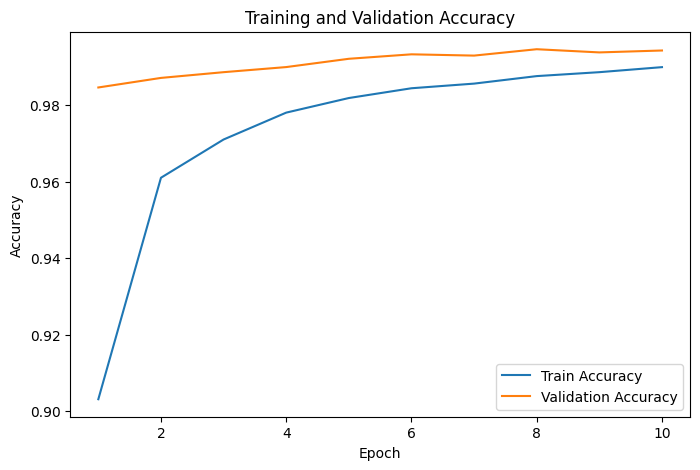

In [6]:
#Plot train/validation accuracy
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_accs, label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [7]:
# Test data (no augmentation)
x_test_prep, y_test_prep = preprocess_pipeline(
    x_test, y_test, augment=False
)
# Convert test data to tensors
x_test_tensor = torch.tensor(x_test_prep, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_prep, dtype=torch.long)

# Create DataLoader
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = evaluate_model(model, test_loader, device)

print("Test accuracy:", results["accuracy"])

In [ ]:
df = pd.DataFrame(results["classification_report"]).T


df = df.drop(columns=["support"])


df = df.round(4)

print(df)

In [ ]:
# Plot confusion matrix
cm = results["confusion_matrix"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()